In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd "/content/drive/My Drive/Colab Notebooks/BiodivBERT-RE/"

/content/drive/My Drive/Colab Notebooks/BiodivBERT-RE


In [4]:
import os

In [5]:
root_dir = "/content/drive/My Drive/Colab Notebooks/BiodivBERT-RE/"

root_data_dir = os.path.join(root_dir, "datasets", "GAD")
print(root_data_dir)

dataset = "train"
csv_file_path = "train.csv"

offline_model_file = os.path.join(root_dir, "BiLSTM-GAD-model")
training_history_csv = "training_history.csv"

/content/drive/My Drive/Colab Notebooks/BiodivBERT-RE/datasets/GAD


## Util

In [6]:
def load_model():
    json_file = open(offline_model_file+".json", 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    new_model = model_from_json(loaded_model_json)
    # load weights into new model
    new_model.load_weights(offline_model_file+".h5")
    print("Loaded model from disk")
    return new_model

In [7]:
def save_model(model):
    # serialize model to JSON
    model_json = model.to_json()
    
    with open(offline_model_file+".json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(offline_model_file+".h5")
    print("Saved model to disk")

In [8]:
def saveDataFrameToCSV(pd1, csv_path, append):  
  dataset_path = os.path.join(root_dir, csv_path)  
  
  if append:
    with open(dataset_path, 'a+') as f:    
      pd1.to_csv(dataset_path,  mode='a', index=False, header=False)    
  else:
    with open(dataset_path, 'a+') as f:    
      pd1.to_csv(dataset_path,  mode='a', index=False, header=True)

## Dataset Preprocessing


In [9]:
import os
import pandas as pd
import numpy as np

In [10]:
def loadData(csv_file_path, header=None, index_col=None):
  dataset_path = os.path.join(root_data_dir, csv_file_path)
  data = pd.read_csv(dataset_path, encoding="latin1", sep=',', header=header, index_col=index_col)
  data = data.fillna(method="ffill")
  return data

In [11]:
data_train = loadData(csv_file_path='train.csv', header=0, index_col=None)

In [12]:
data_train.head(10)

,sentence,label
0,this study proposes that A/A genotype at posit...,1
1,Common polymorphisms in the genes @GENE$ and L...,1
2,Results do not support any overall association...,1
3,@GENE$ methylation occurs frequently in human ...,0
4,"In conclusion, @GENE$ 8092C > A polymorphism m...",1
5,Allele A in @GENE$ gene +252 site can signific...,1
6,Our data indicate that the -160 single nucleot...,1
7,These results suggest that the @GENE$/-159 pol...,0
8,there is no evidence for an association of @GE...,1
9,The association between the @GENE$ G allele an...,1


In [13]:
data_test = loadData(csv_file_path='test.csv', header=0, index_col=None)

In [14]:
data_test.head(10)

,sentence,label
0,Our findings indicate that the @GENE$ @DISEASE...,0
1,The results suggest that the @GENE$ gene may n...,0
2,These results suggest that unlike for other ca...,1
3,Our findings suggest that the @GENE$-repeat po...,0
4,The findings of this large study strongly supp...,0
5,These studies support that @GENE$ mutations ar...,0
6,These results suggest that @GENE$ variants may...,1
7,The data obtained in the present study strengt...,0
8,We observed that @GENE$ G395A polymorphism was...,0
9,Our results provide no evidence for an associa...,1


In [15]:
data_dev = loadData(csv_file_path='dev.csv', header=0, index_col=None)

In [16]:
data_dev.head(10)

,sentence,label
0,"Deteriorating gallbladder contractions, possib...",1
1,Our results do not indicate an effect of @GENE...,0
2,It is unlikely that the promoter polymorphisms...,1
3,Although the effects of the A(-173) allele wer...,0
4,Variation in the preproghrelin gene is not ass...,0
5,"In conclusion, our findings support the hypoth...",0
6,The results of this study link @GENE$ (@DISEAS...,0
7,The deletion mutation in exon 11 in @GENE$ gen...,1
8,These data suggest that @GENE$ variation contr...,1
9,The results indicate that @GENE$(V617F) @DISEA...,0


In [17]:
print(len(data_train), len(data_test), len(data_dev))

4097 512 513


### Sentences 

In [18]:
train_texts = data_train[data_train.columns[0]].to_list()
train_labels = data_train[data_train.columns[1]].to_list()

In [19]:
test_texts = data_test[data_test.columns[0]].to_list()
test_labels = data_test[data_test.columns[1]].to_list()

In [20]:
dev_texts = data_dev[data_dev.columns[0]].to_list()
dev_labels = data_dev[data_dev.columns[1]].to_list()

#### Exploration

In [21]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")

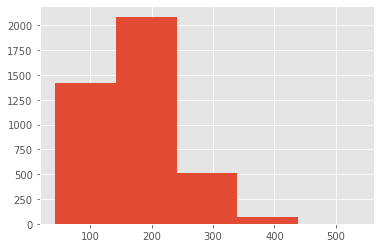

In [22]:
plt.hist([len(s) for s in train_texts], bins=5)
plt.show()

In [23]:
max([len(s) for s in train_texts])

538

In [24]:
max_len = 128 #selected value outisde the histogram

In [25]:
vocab_txt = []
vocab_txt.extend(train_texts)
print(len(vocab_txt))
vocab_txt.extend(test_texts)
print(len(vocab_txt))
vocab_txt.extend(dev_texts)
print(len(vocab_txt))

4097
4609
5122


In [26]:
from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.


In [27]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(vocab_txt)
print("The document count", tokenizer.document_count)
print("The count of words", tokenizer.word_counts)
print("The word index", tokenizer.word_index)

The document count 5122
The count of words OrderedDict([('this', 852), ('study', 584), ('proposes', 1), ('that', 3100), ('a', 2872), ('genotype', 499), ('at', 296), ('position', 19), ('607', 3), ('in', 5926), ('gene', 7103), ('can', 99), ('be', 1197), ('used', 34), ('as', 533), ('new', 23), ('genetic', 740), ('maker', 1), ('thai', 2), ('population', 698), ('for', 1650), ('predicting', 17), ('disease', 5439), ('development', 473), ('common', 236), ('polymorphisms', 709), ('the', 9181), ('genes', 301), ('and', 4024), ('loc387715', 3), ('are', 716), ('independently', 58), ('related', 274), ('to', 2573), ('progression', 108), ('after', 78), ('adjustment', 3), ('other', 167), ('known', 20), ('amd', 22), ('risk', 1529), ('factors', 203), ('results', 1117), ('do', 285), ('not', 1386), ('support', 323), ('any', 75), ('overall', 49), ('association', 731), ('of', 6219), ('ala', 15), ('9val', 4), ('polymorphism', 1272), ('methylation', 1), ('occurs', 6), ('frequently', 8), ('human', 108), ('colon

In [28]:
n_words = len(tokenizer.word_index.keys())

In [29]:
n_words

6744

In [30]:
len(train_texts)

4097

### X & Y Prep

In [31]:

from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

def getXYFromSentences(txts, lbls):
  sequences = tokenizer.texts_to_sequences(txts)
  X = pad_sequences(maxlen=max_len, sequences=sequences, padding="post", truncating="post")
  # X = tokenizer.sequences_to_matrix(X)
  y = np.array(lbls)
  # y = np.array([to_categorical(i, num_classes=2) for i in y])
  print(X.shape)
  print(X[0:3])
  print(y.shape)
  print(y[0:3])
  return X, y

In [32]:
X_train, y_train = getXYFromSentences(train_texts, train_labels)

(4097, 128)
[[  24   36 4067    7    8    8   39   63  636 2364    4    2    2  149
    18  397   38    8  551   27 4068    4 2953   33   11  713    5   42
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [  75   32    4    1   58    2    6 2365   30  241   69   10    5  139
   187 2366   11   96  614  571   13   83    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0   

In [33]:
X_dev, y_dev = getXYFromSentences(dev_texts, dev_labels)

(513, 128)
[[2589 2590 3948  302  358   62  511    4    1    2    2   38  147   38
  2149 1309    2   17 1865    5  516    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [  21   20   66   14   61   26   82    3    2 1116   45 2350    5 1038
     6  321    4 6450  206    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    

In [34]:
X_test, y_test = getXYFromSentences(test_texts, test_labels)

(512, 128)
[[  21   43   61    7    1    2    5   17   16   14   18   15    9   13
     3  234   55    4    1   60   33    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   1   20   19    7    1    2    2   16   14   18   74    4    1  156
     6    5    3  120    4    1   60   33    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    

## BiLSTM Model

In [35]:
from keras import callbacks
from keras.models import Model, Input, model_from_json
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras.optimizers import RMSprop

In [36]:
def create_model():
  input = Input(shape=(max_len,))
  #in the line below --> laurance set the input_length = max_len-1 (NLP in TF Week4)
  model = Embedding(input_dim=n_words, output_dim=50, input_length=max_len)(input)
  model = Dropout(rate=0.1)(model)
  model = Bidirectional(LSTM(units=100, return_sequences=False, recurrent_dropout=0.1))(model)
  model = Dropout(rate=0.25)(model)
  model = Dense(512, activation='relu')(model)  
  model = Dropout(rate=0.25)(model)
  out = Dense(1,  activation='sigmoid')(model)  # segmoid output layer (binary classification)
  
  return Model(input, out)

In [37]:
model = create_model()
#model = load_model()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [38]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 128, 50)           337200    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 50)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               120800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               102912    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0   

In [39]:
from tensorflow.keras.losses import BinaryCrossentropy

In [40]:
model.compile(optimizer=RMSprop(),loss=BinaryCrossentropy(reduction='sum_over_batch_size'), metrics=["accuracy"])
# model.compile(optimizer=RMSprop(),loss=BinaryCrossentropy(reduction='none'), metrics=["accuracy"])
# model.compile(optimizer=RMSprop(),loss="mse", metrics=["accuracy"])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [41]:
class myCallback(callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>=0.989):
      print("\nReached 98.9% accuracy so cancelling training!")
      self.model.stop_training = True
 

In [42]:
history = model.fit(X_train, y_train, validation_data=(X_dev, y_dev), shuffle=True, batch_size=32, epochs=10, verbose=1, callbacks=[myCallback()])


Train on 4097 samples, validate on 513 samples
Epoch 1/10
4097/4097 [==============================] - 33s 8ms/step - loss: 0.6849 - accuracy: 0.5465 - val_loss: 0.6855 - val_accuracy: 0.5536
Epoch 2/10
4097/4097 [==============================] - 34s 8ms/step - loss: 0.6232 - accuracy: 0.6471 - val_loss: 0.7271 - val_accuracy: 0.5556
Epoch 3/10
4097/4097 [==============================] - 32s 8ms/step - loss: 0.5414 - accuracy: 0.7300 - val_loss: 0.7493 - val_accuracy: 0.5692
Epoch 4/10
4097/4097 [==============================] - 32s 8ms/step - loss: 0.4775 - accuracy: 0.7776 - val_loss: 0.7610 - val_accuracy: 0.5595
Epoch 5/10
4097/4097 [==============================] - 32s 8ms/step - loss: 0.4285 - accuracy: 0.8084 - val_loss: 0.8192 - val_accuracy: 0.5789
Epoch 6/10
4097/4097 [==============================] - 32s 8ms/step - loss: 0.3970 - accuracy: 0.8228 - val_loss: 0.8364 - val_accuracy: 0.5731
Epoch 7/10
4097/4097 [==============================] - 32s 8ms/step - loss: 0.365

In [43]:
save_model(model)

Saved model to disk


In [44]:
hist = pd.DataFrame(history.history)

In [45]:
saveDataFrameToCSV(hist, training_history_csv, append=True)
 

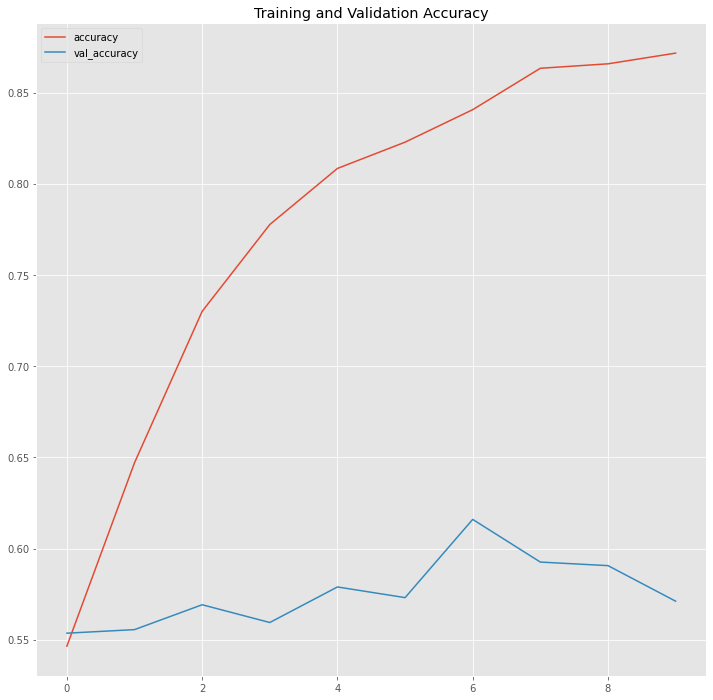

In [46]:
plt.figure(figsize=(12,12))
plt.plot(hist["accuracy"], label="accuracy")
plt.plot(hist["val_accuracy"], label="val_accuracy")
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

## Evaluation

In [47]:
model.evaluate(x=X_test, y=y_test, batch_size=32, verbose=1)

512/512 [==============================] - 2s 4ms/step


[0.830559141933918, 0.658203125]

In [48]:
test_pred = model.predict(X_test, verbose=1)

512/512 [==============================] - 2s 4ms/step


In [49]:
pred_labels = [ 1 if t >= 0.5 else 0 for t in test_pred]

In [50]:
test_pred[0:10]

array([[0.06830359],
       [0.30851483],
       [0.88923836],
       [0.74985445],
       [0.51577264],
       [0.96697724],
       [0.6502274 ],
       [0.08289278],
       [0.01255524],
       [0.5194386 ]], dtype=float32)

In [51]:
pred_labels[0:10]

[0, 0, 1, 1, 1, 1, 1, 0, 0, 1]

In [52]:
test_labels[0:10]

[0, 0, 1, 0, 0, 0, 1, 0, 0, 1]

In [53]:
from classification_metrics import classification_report, replaceMultiple

In [54]:
print(classification_report(test_labels, pred_labels))

                        precision 	 recall 	 f1-score 	 support

                   0	 0.69		 0.59		 0.64		 259	
                   1	 0.64		 0.72		 0.68		 253	


macro avg           	 0.66		 0.66		 0.66		 512	
micro avg           	 0.66		 0.66		 0.66		 512	

